In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, Polygon
import math
import matplotlib
import h3pandas

In [2]:
# don't use the full dataset too large for common notebook
# data = gpd.read_file("data-tmp/kontur_population_20220630.gpkg/kontur_population.gpkg")
# data.head()

kontour = gpd.read_file('data-tmp/kontur_population_MQ_20220630.gpkg').to_crs(epsg=4326)
#kontour.plot(column='population', figsize=(10,10))
kontour.population.sum()

1090147.0

In [3]:
import pyproj
crs_5490 = pyproj.crs.CRS.from_user_input("""
PROJCRS["RGAF09 / UTM zone 20N",
    BASEGEOGCRS["RGAF09",
        DATUM["Reseau Geodesique des Antilles Francaises 2009",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",5489]],
    CONVERSION["UTM zone 20N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-63,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["Engineering survey, topographic mapping."],
        AREA["French Antilles onshore and offshore west of 60°W - Guadeloupe (including Grande Terre, Basse Terre, Marie Galante, Les Saintes, Iles de la Petite Terre, La Desirade); Martinique; St Barthélemy; northern St Martin."],
        BBOX[14.08,-63.66,18.31,-60]],
    ID["EPSG",5490]]
""")

MQ_CARREAU_200_2017 = 'data/Filosofi2017_carreaux_200m_mart.csv'
df = pd.read_csv(MQ_CARREAU_200_2017)
df['n'] = df['Idcar_200m'].str[15:22].astype(int)
df['e'] = df['Idcar_200m'].str[23:].astype(int)
df['geometry'] = df[['n', 'e']].apply(lambda x: Polygon([[x[1] + dy, x[0] + dx] for dx in [0,199] for dy in [199, 0]]), axis=1)
df['rev'] = df['Ind_snv'] / df['Ind']

car = gpd.GeoDataFrame(df)
car = car.set_crs(crs_5490, allow_override=True)
car = car.to_crs(epsg=4326)

In [8]:
COMMUNES_FILES = 'data/communes-martinique.geojson'
resolution = 8
gdf = gpd.read_file(COMMUNES_FILES).h3.polyfill_resample(resolution).drop(columns=['index']).reset_index()

ccar = gdf.merge(gpd.sjoin(gdf, car, how="right", predicate='intersects').groupby(by='h3_polyfill').agg(nb=('Ind', 'sum')).reset_index(), on='h3_polyfill', how='left').fillna(0)
z = ccar.merge(gpd.sjoin(ccar, kontour, how='right', predicate='intersects').groupby(by='h3_polyfill').agg(population=('population', 'sum')).reset_index(), on='h3_polyfill', how='left').fillna(0)

print("insee=", z.nb.sum(), "kontour=", kontour.population.sum())

insee= 526830.0 kontour= 1090147.0


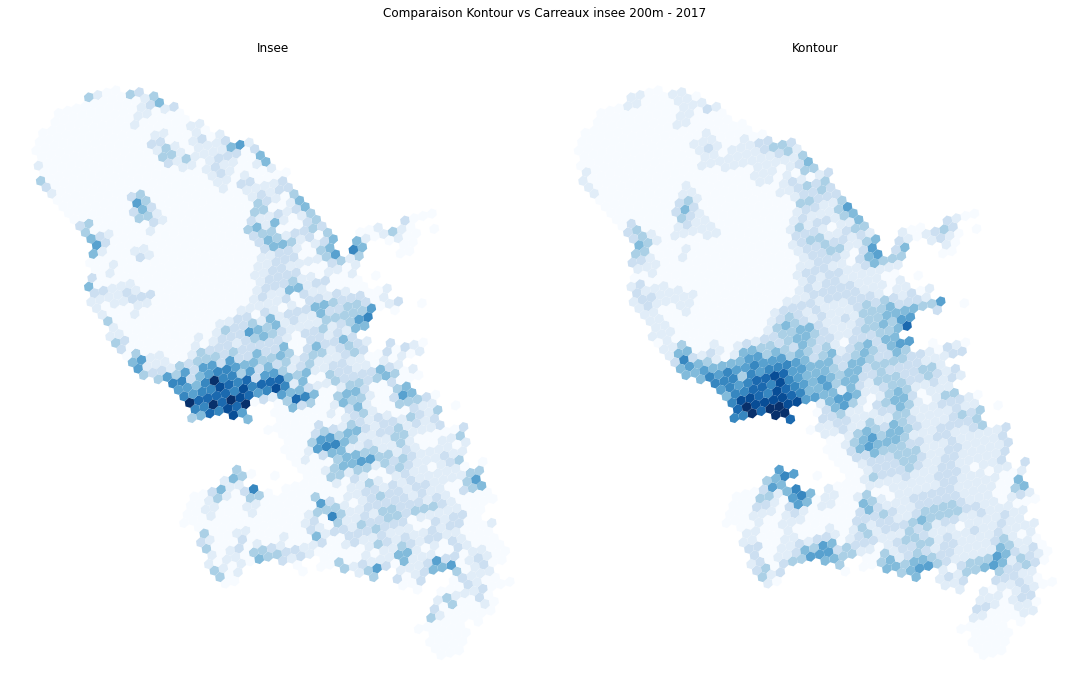

In [9]:
cmap = matplotlib.cm.Blues

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 10))
fig.suptitle("Comparaison Kontour vs Carreaux insee 200m - 2017")

z.plot(ax=ax1, column='nb',  
         k=10, legend=False, cmap=cmap, scheme='NaturalBreaks',
)
ax1.set_title('Insee')
z.plot(ax=ax2, column='population',
         k=10, legend=False, cmap=cmap, scheme='NaturalBreaks',
)
ax2.set_title('Kontour')
_ = ax1.axis("off")
_ = ax2.axis("off")
fig.savefig('output-tmp/2022-11-21.png', facecolor='white')